In [25]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot


In [2]:
def get_avg_spectrogram(smg, traces_frame, time_frame_width=100, noverlap=None, do_time_avg=True):
    x = smg[traces_frame]
    f, t, Sxx = signal.spectrogram(x, window=('tukey', 0.25), nperseg=time_frame_width, noverlap=noverlap)
    avg_spec = Sxx.mean(axis=0)
    if do_time_avg:
        avg_spec = avg_spec.mean(axis=-1)
    return avg_spec

def get_spectrogram_dist_heatmap(smgr, smgl, n_trace_frames, time_frame_width=100, noverlap=None, mode='max_abs'):
    results = None
    traces_frame_width = smgr.shape[0] // n_trace_frames
    for tf in range(n_trace_frames):
        frame_begin = traces_frame_width * tf
        traces_frame = slice(frame_begin, frame_begin + traces_frame_width)

        kwargs = dict(time_frame_width=time_frame_width, do_time_avg=False, noverlap=noverlap)
        sl = get_avg_spectrogram(smgl, traces_frame, **kwargs)
        sr = get_avg_spectrogram(smgr, traces_frame, **kwargs)

        if callable(mode):  # res(sl, sr)
            res = mode(sl, sr)
        elif mode == 'max_abs':
            res = np.abs(sl - sr).max(axis=0)
        elif mode == 'sum_abs':
            res = np.sum(np.abs(sl - sr), axis=0)
        elif mode == 'sum_sq':
            res = np.sum(np.abs(sl - sr) ** 2, axis=0)
        else:
            raise NotImplemented('modes other than max_abs, sum_abs, sum_sq not implemented yet')

        if results is None:
            results = res
        else:
            results = np.vstack((results, res))
    return results

def draw_heatmaps(smgrs, smgls, n_trace_frames, time_frame_width=100, noverlap=None,
                  mode='max_abs', cv_res=None, figsize=(15, 15)):
    cv_smg = np.abs(np.quantile(np.stack(smgrs), 0.1))

    fig, axs = plt.subplots(len(smgrs), 3, figsize=figsize)

    for smgr, smgl in zip(smgrs, smgls):
        results = get_stft_dist_heatmap(smgr, smgl, n_trace_frames, time_frame_width, noverlap, mode)

        axs[field, 0].imshow(smgr.T, vmin=-cv_smg, vmax=cv_smg, cmap='gray', aspect='auto')
        axs[field, 1].imshow(smgl.T, vmin=-cv_smg, vmax=cv_smg, cmap='gray', aspect='auto')
        axs[field, 2].imshow(results.T, vmin=0, vmax=cv_res, cmap='gray', aspect='auto')

In [39]:
def draw_modifications(modifications, vmin=None, vmax=None, figsize=(15, 15), time_frame_width=100, noverlap=None, mode='max_abs'):
    fig, axs = plt.subplots(1, len(modifications), figsize=figsize)    
    origin, _ = modifications[0]
    
    for i, (mod, description) in enumerate(modifications):
        dist_v = get_spectrogram_dist_heatmap(mod, origin, n_trace_frames=1, time_frame_width=time_frame_width, noverlap=noverlap, mode=mode)
        dist = np.mean(dist_v)

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        axs[i].set_title("{},\ndist from original is: {:.4}".format(description, dist))

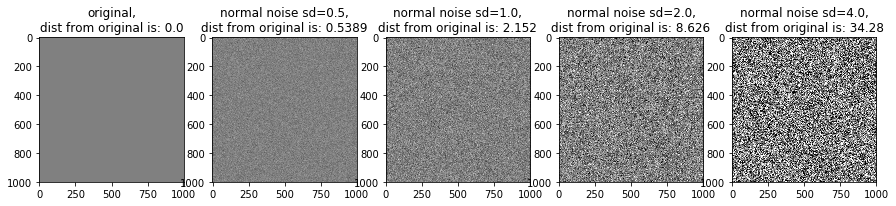

In [16]:
origin_shape = (1000, 1000)
origin = np.zeros(shape=origin_shape)
modifications = [(origin, "original")]
for i in range(1,5):
    mod = origin + np.random.normal(scale=2**i/4, size=origin_shape)
    modifications.append((mod, "normal noise sd={}".format(2**i/4)))
                         
draw_modifications(modifications, vmin=-6, vmax=6)    

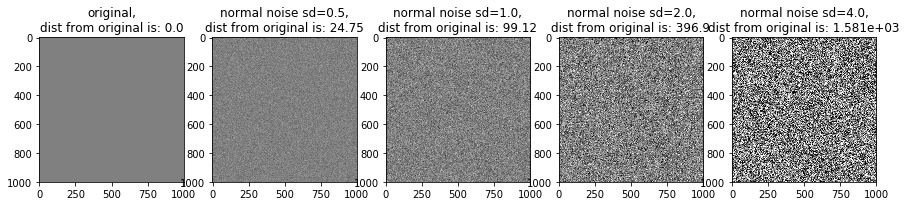

In [19]:
draw_modifications(modifications, vmin=-6, vmax=6, mode='sum_abs')    

In [17]:
raw = np.load('raw_1.npy')
lift = np.load('lift_1.npy')
out = np.load('out_1.npy')
att = np.load('att_1.npy')

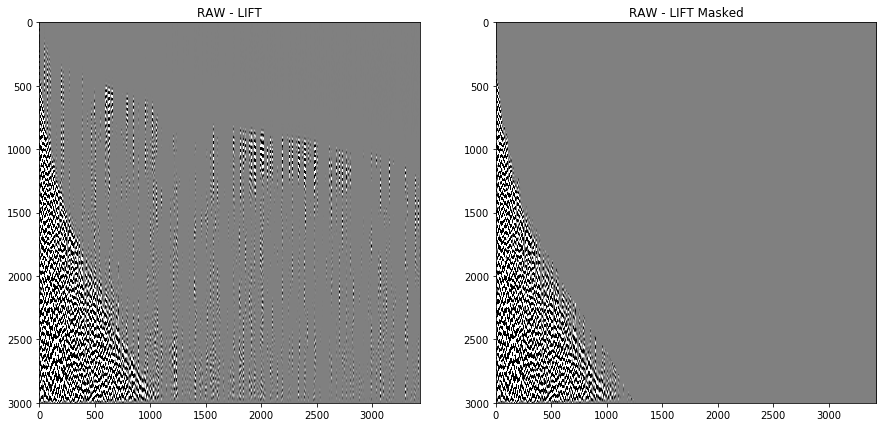

In [26]:
diff = raw - lift
diff_m = diff * (1 - att)

cv = 0.1
seismic_plot([diff, diff_m], figsize=(15, 7), names=['RAW - LIFT', 'RAW - LIFT Masked'],
             cmap='gray', vmin=-cv, vmax=cv)

In [52]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + diff_m * scale
    modifications.append((mod, "noise diff scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

In [53]:
def get_cv(arrs, q=0.95):
    return np.abs(np.quantile(np.stack(item for item in arrs), q))

In [54]:
cv = get_cv([raw])

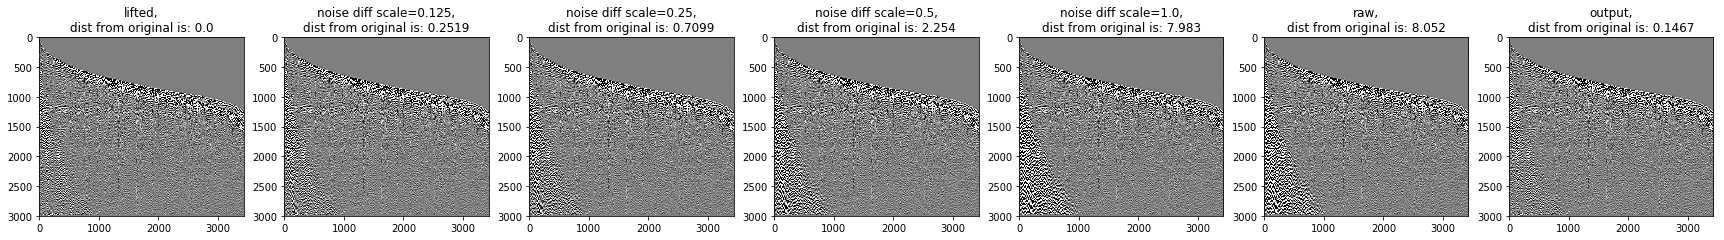

In [56]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

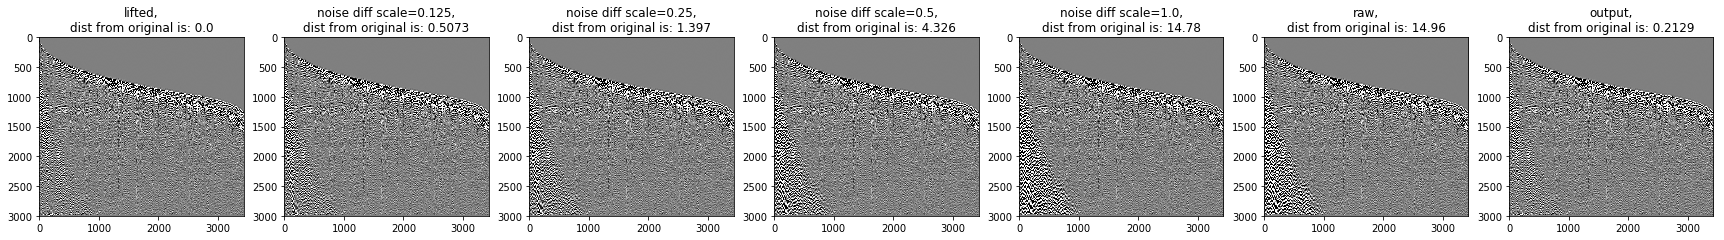

In [55]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

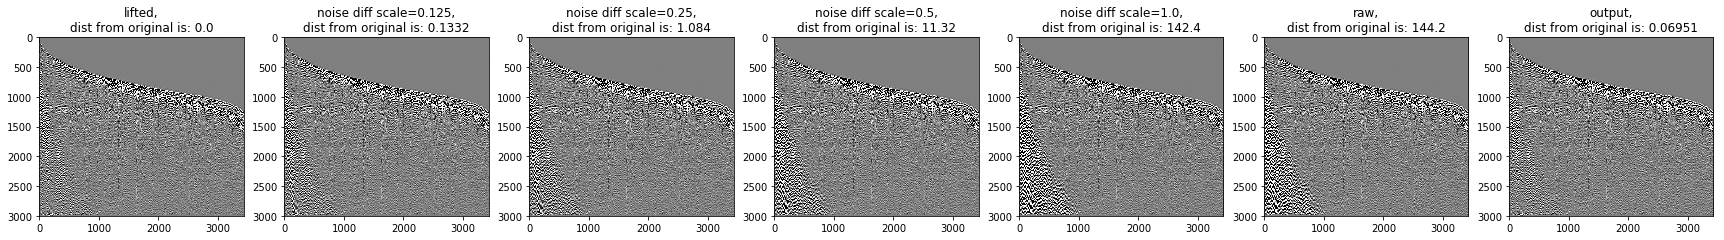

In [57]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))  

In [60]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + np.random.normal(scale=scale, size=raw.shape) * (1 - att)
    modifications.append((mod, "normal noise scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

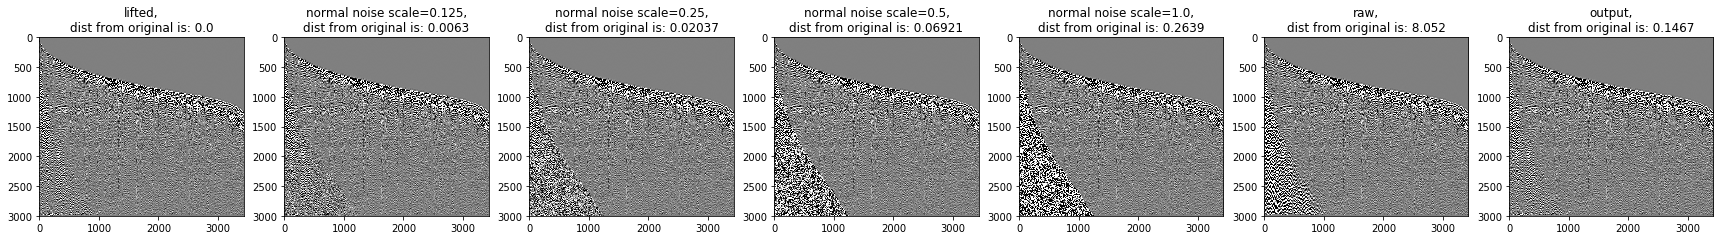

In [61]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

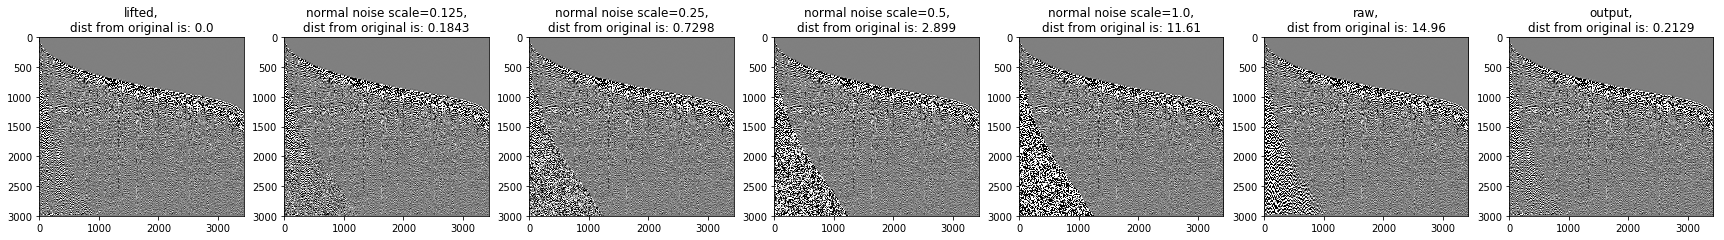

In [62]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

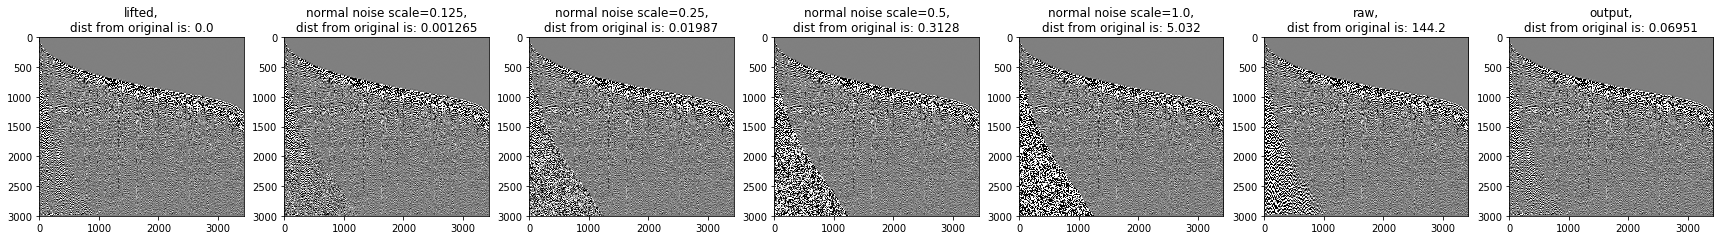

In [63]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))    